In [50]:
import numpy as np
import pandas as pd

import requests

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [51]:
import pathlib

In [52]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

In [53]:
from statistics import mean
from collections import defaultdict
import json
import requests

# from datetime import datetime, timedelta
# 
data = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&apikey=ECJCTAUGNRXNF2LN&outputsize=full')
data = data.json().get('Time Series (Daily)')
filtered_data = {k: v for k, v in data.items() if k.startswith("2023")}
array_data = [[k] + list(v.values()) for k, v in filtered_data.items()]

In [54]:
with open('data.json') as f:
    data = json.load(f)

sentiments_by_date = defaultdict(list)
for item in data:
    for sentiment in item['ticker_sentiment']:
        if sentiment['ticker'] == 'AAPL':
            key = item['time_published'][:4] + "-" + item['time_published'][4:6] + "-" + item['time_published'][6:8]
            sentiments_by_date[key].append(float(sentiment['ticker_sentiment_score']) * float(sentiment['relevance_score']))

# # Calculate the average sentiment score for each day
average_sentiments = {date: mean(scores) for date, scores in sentiments_by_date.items()}
# 
average_sentiments_df = pd.DataFrame(list(average_sentiments.items()), columns=['date', 'average_sentiment'])
# 
# # Convert array_data to DataFrame
array_data_df = pd.DataFrame(array_data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
# 
# # Merge the two DataFrames on the date column
df = pd.merge(array_data_df, average_sentiments_df, on='date')

df = df.set_index('date').sort_index()

df = df.drop(columns=['high', 'low', 'volume'])

df = df[['close', 'open', 'average_sentiment']]

df

,close,open,average_sentiment
date,,,
2023-01-03,125.0700,130.2800,-0.012122
2023-01-04,126.3600,126.8900,0.003101
2023-01-05,125.0200,127.1300,0.002291
2023-01-06,129.6200,126.0100,0.043935
2023-01-09,130.1500,130.4650,0.023758
...,...,...,...
2023-12-22,193.6000,195.1800,0.042874
2023-12-26,193.0500,193.6100,0.037143
2023-12-27,193.1500,192.4900,0.003840


In [55]:
scaler = MinMaxScaler()
scaler = scaler.fit(df.iloc[:-30, :])
df_for_training_scaled = scaler.transform(df)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(pd.DataFrame(df.iloc[:-30,0]))

array([[6.99986000e-04],
       [1.87596248e-02],
       [0.00000000e+00],
       [6.43987120e-02],
       [7.18185636e-02],
       [7.99384012e-02],
       [1.18577628e-01],
       [1.17457651e-01],
       [1.36357273e-01],
       [1.52876942e-01],
       [1.42657147e-01],
       [1.43497130e-01],
       [1.79896402e-01],
       [2.25255495e-01],
       [2.45135097e-01],
       [2.35755285e-01],
       [2.65154697e-01],
       [2.92734145e-01],
       [2.51714966e-01],
       [2.69774605e-01],
       [2.85734285e-01],
       [3.61192776e-01],
       [4.12711746e-01],
       [3.73932521e-01],
       [4.14811704e-01],
       [3.76592468e-01],
       [3.61892762e-01],
       [3.63852723e-01],
       [4.03611928e-01],
       [3.94512110e-01],
       [4.24331513e-01],
       [4.01651967e-01],
       [3.85412292e-01],
       [3.28433431e-01],
       [3.34453311e-01],
       [3.41313174e-01],
       [3.03653927e-01],
       [3.20593588e-01],
       [3.13453731e-01],
       [2.84054319e-01],


In [110]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))
X_train_lstm_without_news, X_test_lstm_without_news, y_train_lstm_without_news, y_test_lstm_without_news = train_test_split(trainX[:, :, :-1], trainY, test_size=30, shuffle=False)

X_train_lstm_news, X_test_lstm_news, y_train_lstm_news, y_test_lstm_news = train_test_split(trainX, trainY, test_size=30, shuffle=False)

X_train_lstm_without_news.shape,X_train_lstm_news.shape

TrainX shape = (245, 5, 3).
TrainY shape = (245, 1, 1).


((215, 5, 2), (215, 5, 3))

In [111]:
def build_model(input_shape):
    tf.keras.utils.set_random_seed(42)
    model = Sequential()
    
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 128))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [112]:
lstm_model_without_news=build_model((X_train_lstm_without_news.shape[1], X_train_lstm_without_news.shape[2]))
lstm_model_news=build_model((X_train_lstm_news.shape[1], X_train_lstm_news.shape[2]))

history_without_news = lstm_model_without_news.fit(X_train_lstm_without_news, y_train_lstm_without_news, epochs=60, batch_size=64, verbose=1, )

history_news = lstm_model_news.fit(X_train_lstm_news, y_train_lstm_news, epochs=60, batch_size=64, verbose=1, )

C:\Users\Administrator\Desktop\Projects\investify\model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 5, 256)         │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 5, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 987,777 (3.77 MB)

 Trainable params: 987,777 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 5, 256)         │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 5, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 988,801 (3.77 MB)

 Trainable params: 988,801 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.3406
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0400
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0192
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0336
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0097
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0177
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0105
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0101
Epoch 9/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081
Epoch 10/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0079
Epoch 11/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0077
Epoch 12/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060
Epoch 13/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0073
Epoch 14/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058
Epoch 15/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0067
Epoch 16/60
4/4 ━━━━━━━━━━━━━━━━━━

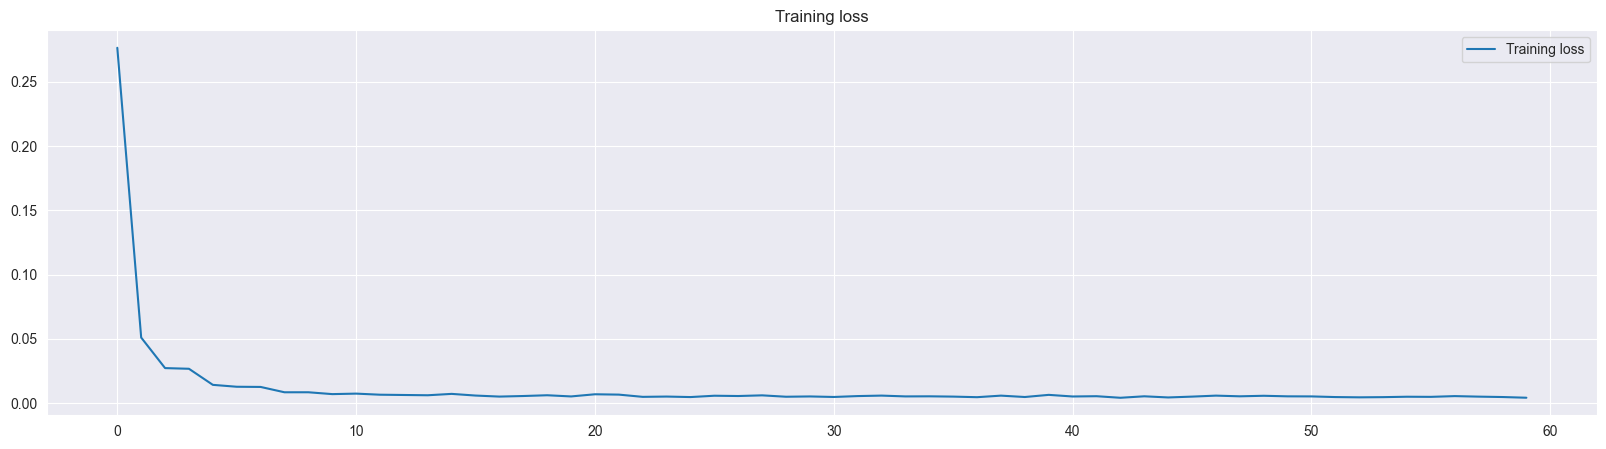

In [113]:
plt.figure(figsize=(20,5))
plt.plot(history_news.history['loss'], label='Training loss')
plt.title('Training loss')
plt.legend()

In [114]:
training_dates= df.index[:X_train_lstm_without_news.shape[0]]
#Make prediction
    
training_prediction_without_news = lstm_model_without_news.predict(X_train_lstm_without_news)

training_prediction_news = lstm_model_news.predict(X_train_lstm_news)

y_train_pred_lstm_without_news = scaler_for_inference.inverse_transform(training_prediction_without_news)

y_train_pred_lstm_news = scaler_for_inference.inverse_transform(training_prediction_news)

y_train_lstm_reshaped_without_news=y_train_lstm_without_news.reshape(y_train_lstm_without_news.shape[0], y_train_lstm_without_news.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_news)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [115]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type, news, dates, y_actual_lstm, y_pred_lstm):
    predicted_features=['close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if news :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding news sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without news sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [116]:
testing_dates= df.index[-X_test_lstm_without_news.shape[0]:]
#Make prediction
testing_prediction_without_news = lstm_model_without_news.predict(X_test_lstm_without_news)
testing_prediction_news = lstm_model_news.predict(X_test_lstm_news)

y_test_pred_lstm_without_news = scaler_for_inference.inverse_transform(testing_prediction_without_news)
y_test_pred_lstm_news = scaler_for_inference.inverse_transform(testing_prediction_news)

y_test_actual_lstm_reshaped_without_news=y_test_lstm_without_news.reshape(y_test_lstm_without_news.shape[0], y_test_lstm_without_news.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_news)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


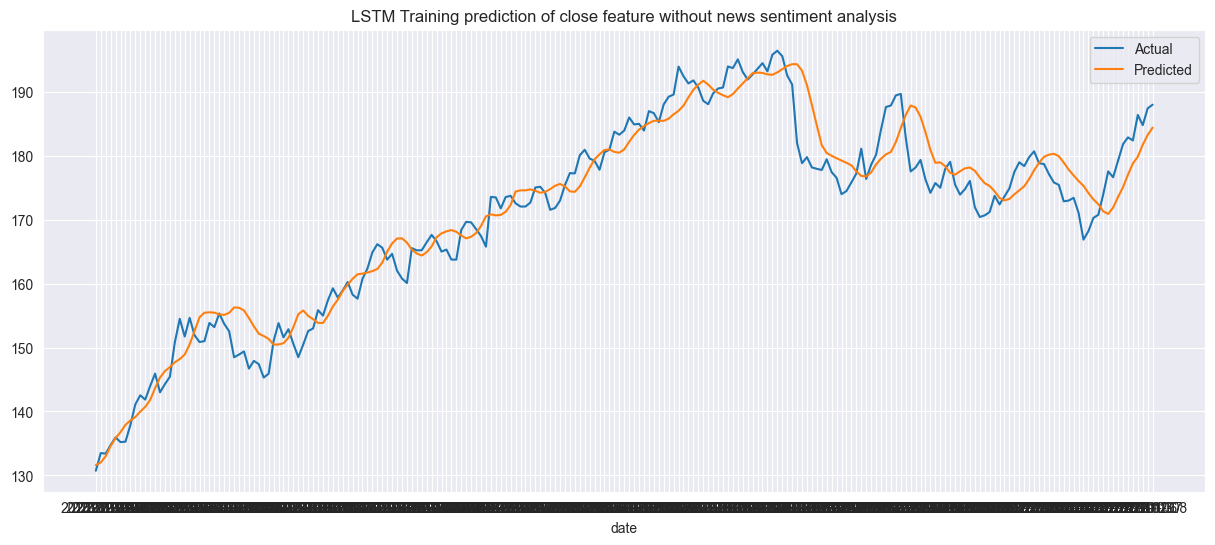

Mean square error for close =15.87135352980037
Total mean square error 15.87135352980037


In [117]:
training_dates= df.index[:X_train_lstm_news.shape[0]]
plot_predictions_with_dates('Training', False, training_dates, y_train_actual_lstm, y_train_pred_lstm_without_news)

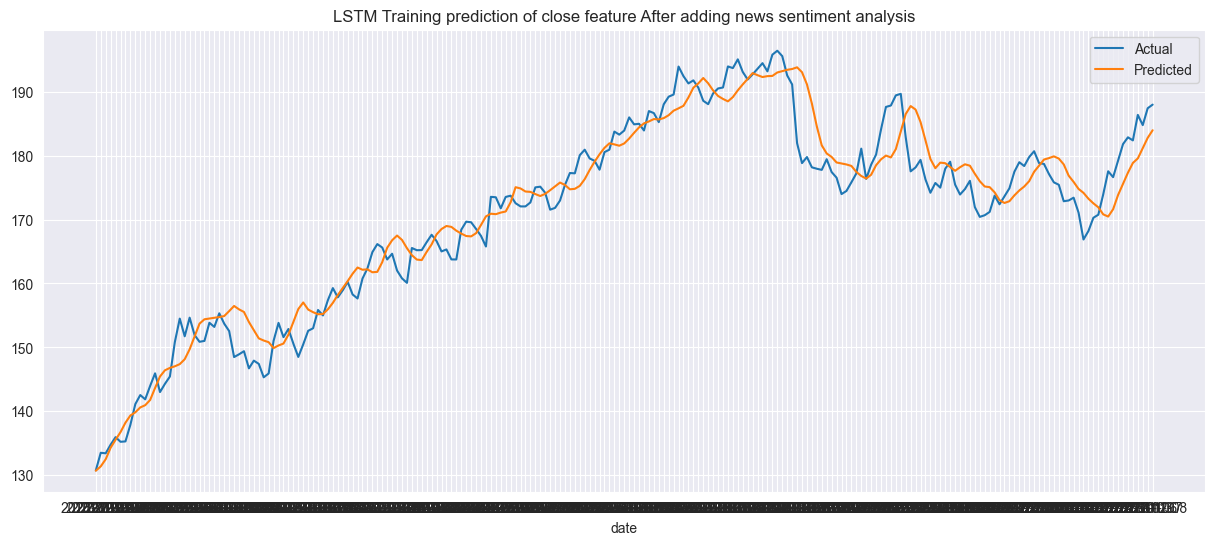

Mean square error for close =15.457636061707888
Total mean square error 15.457636061707888


In [118]:
training_dates= df.index[:X_train_lstm_news.shape[0]]
plot_predictions_with_dates('Training', True, training_dates, y_train_actual_lstm, y_train_pred_lstm_news)

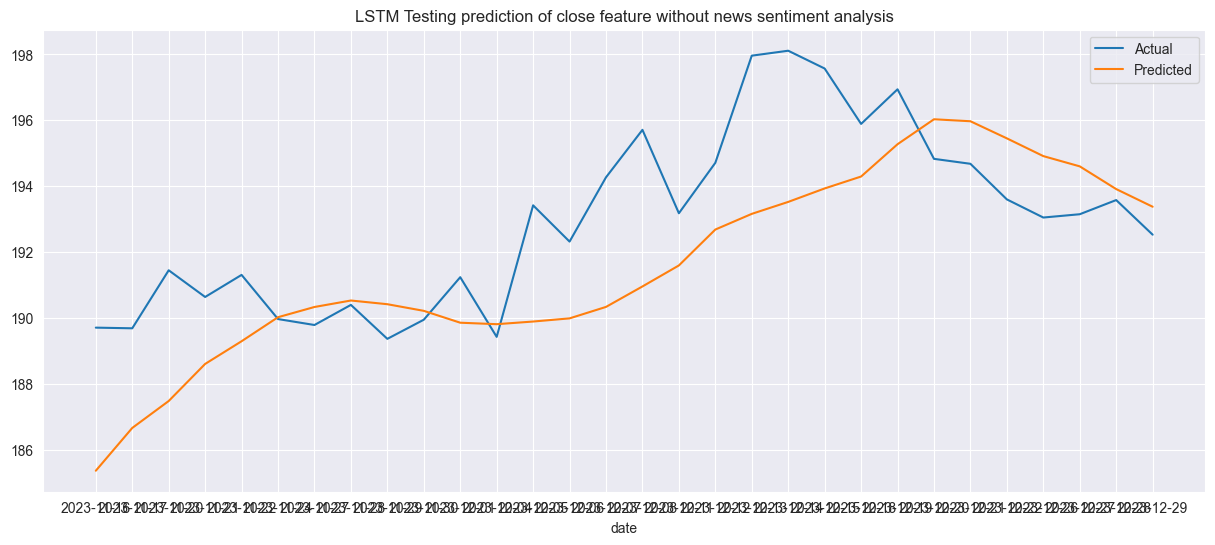

Mean square error for close =6.449008646646273
Total mean square error 6.449008646646273


In [119]:
plot_predictions_with_dates('Testing', False, testing_dates, y_test_actual_lstm, y_test_pred_lstm_without_news)

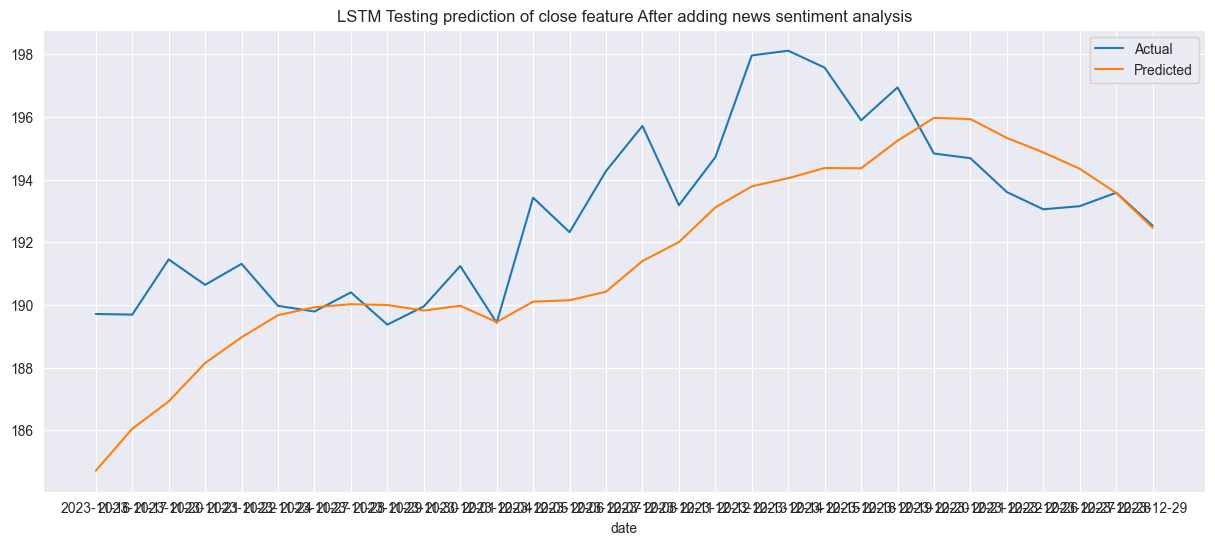

Mean square error for close =6.195467000751822
Total mean square error 6.195467000751822


In [120]:
plot_predictions_with_dates('Testing', True, testing_dates, y_test_actual_lstm, y_test_pred_lstm_news)